In [1]:
%matplotlib inline
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan



In [2]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'
xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
alloc_device_only=True

In [3]:
values = craco.search_pipeline.get_parser().parse_args([])

In [ ]:

device = pyxrt.device(1)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)


In [23]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2")

parsing values --ndm 2


In [24]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

RuntimeError: failed to open ip context: Invalid argument

In [ ]:
def copy_mainbuf(p):
    mainbuf_run = p.all_mainbufs[0]
    main_nuv = mainbuf_run.shape[0]
    mainbuf_shape =list(mainbuf_run.shape[:])
    nbuf = 8
    mainbuf_shape[0] *= nbuf
    mainbuf = np.zeros(mainbuf_shape, dtype=np.int16)
    print(mainbuf_shape)
    for b in range(len(p.all_mainbufs)):
        start = b*main_nuv
        end = (b+1)*main_nuv
        buf = p.all_mainbufs[b]
        buf.copy_from_device()
        d = buf.nparr
        mainbuf[start:end, ...] = d
    # (101, 186, 11, 256, 8, 2)
    return mainbuf

In [8]:
#p.clear_buffers(values)
dmamp = 1024
t0 = 1

# put in a value for a single time and DM
for b in p.all_mainbufs:
    print(b.shape)
    b.nparr[:] = 0
    b.nparr[:,0,0,t0,:,0] = dmamp
    b.copy_to_device()
    

[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]
[83, 32, 11, 256, 8, 2]


In [9]:
mainbuf = copy_mainbuf(p)

[664, 32, 11, 256, 8, 2]


(664, 32, 11, 256, 8, 2)


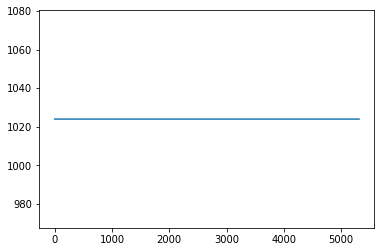

In [10]:
print(mainbuf.shape)
plot(mainbuf[:,0,0,t0,:,0].flat)
assert np.all(mainbuf[:,0,0,t0,:,0] == dmamp)
assert np.all(mainbuf[:,1:,1:,:t0,:,1] == 0)
assert np.all(mainbuf[:,1:,1:,:t0+1,:,1] == 0)

In [11]:
values.run_fdmt = False

In [12]:
waitall(p.run(0, values))

In [13]:
cands = p.get_candidates()

In [14]:
print(cands)
cands = cands[cands['dm'] == 0] # DM 0 adn 1 are repeated, I think.
print(cands)

[(2048,     0, 0, 1, 0) ( 288,    17, 0, 0, 0) ( 414,    33, 0, 0, 0) ...
 ( 413,   511, 7, 8, 1) ( 413, 65281, 7, 8, 1) ( 234, 65535, 7, 8, 1)]
[(2048,     0, 0, 1, 0) ( 288,    17, 0, 0, 0) ( 414,    33, 0, 0, 0) ...
 ( 413,   511, 7, 8, 0) ( 413, 65281, 7, 8, 0) ( 234, 65535, 7, 8, 0)]


(120.0, 136.0)

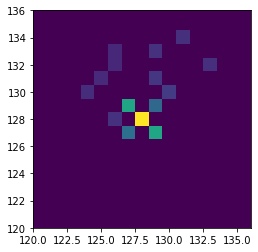

In [15]:
grid = grid_candidates(cands, 'snr')
imshow(grid)
xlim(128-8,128+8)
ylim(128-8,128+8)

In [16]:
print_candidates(cands, 256, 0)

# SNR	upix	vpix	boxc_width	time	dm	iblk

32.0	128	128	0		1	0	0
4.5	145	128	0		0	0	0
6.5	161	128	0		0	0	0
5.2	184	128	0		1	0	0
4.1	200	128	0		1	0	0
3.2	219	128	0		1	0	0
4.4	238	128	0		1	0	0
3.4	252	128	0		0	0	0
4.1	3	128	0		0	0	0
4.8	18	128	1		1	0	0
3.2	37	128	0		1	0	0
4.1	56	128	0		1	0	0
5.2	72	128	0		1	0	0
4.4	94	128	0		0	0	0
3.8	96	128	0		0	0	0
6.2	126	128	0		1	0	0
10.7	129	129	0		1	0	0
4.1	160	129	0		0	0	0
4.0	183	129	0		1	0	0
4.1	201	129	1		1	0	0
5.7	237	129	0		1	0	0
4.2	247	129	0		0	0	0
5.0	2	129	1		1	0	0
5.7	17	129	1		1	0	0
4.3	39	129	0		0	0	0
3.8	74	129	1		1	0	0
3.5	91	129	0		0	0	0
4.0	111	129	0		0	0	0
18.8	127	129	0		1	0	0
7.7	130	130	0		1	0	0
3.7	145	130	0		1	0	0
4.5	160	130	0		1	0	0
3.9	192	130	0		1	0	0
4.2	213	130	0		0	0	0
5.8	238	130	0		1	0	0
4.8	249	130	0		1	0	0
4.3	5	130	1		1	0	0
5.2	18	130	0		1	0	0
4.3	34	130	1		1	0	0
3.5	51	130	0		0	0	0
4.4	79	130	0		0	0	0
3.7	107	130	0		1	0	0
5.6	124	130	1		1	0	0
6.9	129	131	0		1	0	0
4.2	154	131	1		1	0	0
4.0	166	131	0		0	0	0
4.0	181	13

In [17]:
from craft.craco_plan import PipelinePlan
import craco
import craft.craco_plan
from craft import uvfits
from imp import reload
import sys
print(sys.path)
import craco_pybind11
import craco_pybind11.ddgrid_reader
import craco_pybind11.grid
reload(craco_pybind11)

ndm = 1
tblk = 0
NUVWIDE = 8
OUTPUT_NT = 2
OUTPUT_NUV = 2
#nuvrest = nuv // NUVWIDE
#nuvrest = plan.nuvrest
ncu = 4
do_load_lut=1
nchunk_time = plan.nchunk_time
nparallel_uvin, nparallel_uvout, h_nparallel_uvout, lut = get_grid_lut_from_plan(plan)
nuvrest = nparallel_uvin*2//8
print(nparallel_uvin, nparallel_uvout, h_nparallel_uvout)
print(lut)
outputs = np.zeros((ncu, ndm, nchunk_time, nuvrest, NUVWIDE//OUTPUT_NUV, OUTPUT_NT, OUTPUT_NUV, 2), dtype=np.int16)
ddreader_lut = np.zeros(1024+plan.nuvrest,dtype=np.uint32)

['/opt/xilinx/xrt/python', '/data/craco/ban115/craco-python/notebooks', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages', '/data/craco/ban115/realtime_pipeline_master/python/craco_testing/src', '/data/craco/ban115/craft-github/src', '/data/craco/ban115/craco-python/src', '/data/craco/ban115/realtime_pipeline_master/python/craco_pybind11', '/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/IPython/extensions', '/home/ban115/.ipython']
2636 2681 2662
[0 1 2 ... 0 0 0]


(664, 32, 11, 256, 8, 2)


AssertionError: 

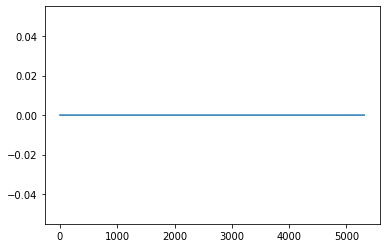

In [18]:
print(mainbuf.shape)
plot(mainbuf[:,0,0,0,:,0].flat)
assert np.all(mainbuf[:,0,0,0,:,0] == 64)

In [ ]:
craco_pybind11.ddgrid_reader.krnl_ddgrid_reader_4cu(mainbuf, 
                                     ndm, 
                                     tblk,
                                     nchunk_time, 
                                     nuvrest, 
                                     ddreader_lut, 
                                     do_load_lut, 
                                     outputs[0], 
                                     outputs[1], 
                                     outputs[2], 
                                     outputs[3])
reordered = np.transpose(outputs, [1, 2,0,5, 3,4,6, 7])
#assert reordered.shape == (ndm, nchunk_time, ncu, OUTPUT_NT, nuvrest, NUVWIDE, 2)
reordered = reordered.reshape(ndm, ncu*nchunk_time*OUTPUT_NT, nuvrest*NUVWIDE, 2)